In [13]:
# CONFIGS

# Must be a doc2vec model file, not a word2vec bin/txt as it does not preserve document vectors.
doc2vec_model_file = "word2vec/d2v-imdb-dm-100d.model"
doc2vec_dims = 100

# Can easily swap with other datasets if you want
positive_review_txts = "aclImdb/train/pos/*.txt"
negative_review_txts = "aclImdb/train/neg/*.txt"
positive_review_vals = "aclImdb/test/pos/*.txt"
negative_review_vals = "aclImdb/test/neg/*.txt"
# positive_review_txts = "polarity2/txt_sentoken/pos/*.txt"
# negative_review_txts = "polarity2/txt_sentoken/neg/*.txt"
# positive_review_vals = "polarity2/txt_sentoken/pos/*.txt"
# negative_review_vals = "polarity2/txt_sentoken/neg/*.txt"

positive_y = [1, 0]
negative_y = [0, 1]

# Test theano and graphics card
import theano.tensor as T

# Notebook
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

## Step 1: Make X_train

X_train data structure is a 3D array, consisting of reviews, words, and vectors:
```json
[
  // a review
  [
    // a word, and its array of 100 vectors
    [0.75, 0.64 ...],
    ...
  ], 
  ...
]
```


In [14]:
from bs4 import BeautifulSoup  
import re

def normalise_text(text):
    #1 Remove HTML (inspired by Kaggle)
    text = BeautifulSoup(text, "html.parser").getText()

    #2 Tokenize (stolen from Yoon Kim's CNN)
    text = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", text)     
    text = re.sub(r"\'s", " \'s", text) 
    text = re.sub(r"\'ve", " \'ve", text) 
    text = re.sub(r"n\'t", " n\'t", text) 
    text = re.sub(r"\'re", " \'re", text) 
    text = re.sub(r"\'d", " \'d", text) 
    text = re.sub(r"\'ll", " \'ll", text) 
    text = re.sub(r",", " , ", text) 
    text = re.sub(r"!", " ! ", text) 
    text = re.sub(r"\(", " \( ", text) 
    text = re.sub(r"\)", " \) ", text) 
    text = re.sub(r"\?", " \? ", text) 
    text = re.sub(r"\s{2,}", " ", text)
    
    # Step 3: 
    return text.lower()

def text_tokens(text):
    return normalise_text(text).split()

('highest word count: ', 2606)
('mean of review length: ', 253.51831999999999)


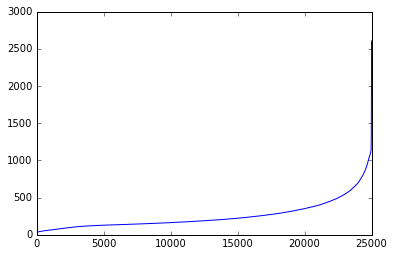

In [15]:
import glob

# highest word count shall be the convnet rows
highest_review_word_count = 0
positive_reviews = []
negative_reviews = []
positive_testrev = []
negative_testrev = []

# to visualise review length
training_review_length = []

for txt in glob.glob(positive_review_txts):
    with (open(txt, 'r')) as f:
        word_array = text_tokens(f.read())
        highest_review_word_count = max(highest_review_word_count, len(word_array))
        positive_reviews.append(word_array)
        training_review_length.append(len(word_array))

for txt in glob.glob(negative_review_txts):
    with (open(txt, 'r')) as f:
        word_array = text_tokens(f.read())
        highest_review_word_count = max(highest_review_word_count, len(word_array))
        negative_reviews.append(word_array)
        training_review_length.append(len(word_array))
        
# For validation purposes
for txt in glob.glob(positive_review_vals):
    with (open(txt, 'r')) as f:
        word_array = text_tokens(f.read())
        highest_review_word_count = max(highest_review_word_count, len(word_array))
        positive_testrev.append(word_array)

for txt in glob.glob(negative_review_vals):
    with (open(txt, 'r')) as f:
        word_array = text_tokens(f.read())
        highest_review_word_count = max(highest_review_word_count, len(word_array))
        negative_testrev.append(word_array)

print('highest word count: ', highest_review_word_count)

# Plotting length
training_review_length = np.sort(np.array(training_review_length))
print('mean of review length: ', np.mean(training_review_length))
plt.plot(training_review_length)

## Step 2: Infer vector from doc2vec

In [16]:
import sys
import gensim
from gensim.models import Doc2Vec
doc2vec_model = Doc2Vec.load(doc2vec_model_file)

In [17]:
log_counter = 0

X_train = []
Y_train = []
X_test  = []
Y_test  = []

# Due to memory constraint, we only take vectors for first 200 words in movie reviews
for i, review in enumerate(positive_reviews):
    X_train.append(doc2vec_model.infer_vector(review))
    Y_train.append(positive_y)
    log_counter += 1
    if log_counter % 1000 == 0:
        sys.stdout.write("\r{0}".format(log_counter))
        sys.stdout.flush()
    
for i, review in enumerate(negative_reviews):
    X_train.append(doc2vec_model.infer_vector(review))
    Y_train.append(negative_y)
    log_counter += 1
    if log_counter % 1000 == 0:
        sys.stdout.write("\r{0}".format(log_counter))
        sys.stdout.flush()
    
# For validation purposes
for i, review in enumerate(positive_testrev):
    X_test.append(doc2vec_model.infer_vector(review))
    Y_test.append(positive_y)
    log_counter += 1
    if log_counter % 1000 == 0:
        sys.stdout.write("\r{0}".format(log_counter))
        sys.stdout.flush()
    
for i, review in enumerate(negative_testrev):
    X_test.append(doc2vec_model.infer_vector(review))
    Y_test.append(negative_y)
    log_counter += 1
    if log_counter % 1000 == 0:
        sys.stdout.write("\r{0}".format(log_counter))
        sys.stdout.flush()

X_train = np.array(X_train)
Y_train = np.array(Y_train)
X_test  = np.array(X_test)
Y_test  = np.array(Y_test)

50000

In [18]:
print(X_train.shape)
print(Y_train.shape)

(25000, 100)
(25000, 2)


## Step 3: Keras

In [19]:
from keras.models import Model, Sequential
from keras.layers.convolutional import Convolution1D, Convolution2D
from keras.layers.pooling import MaxPooling1D, MaxPooling2D
from keras.layers import Merge, Dense, Dropout, Activation, Input, Flatten
from keras.optimizers import SGD

In [20]:
final_model = Sequential()
final_model.add(Dense(32, input_shape=(doc2vec_dims,)))
final_model.add(Activation('relu'))
final_model.add(Dropout(0.5))
final_model.add(Dense(2))
final_model.add(Activation('softmax'))

sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
final_model.compile(loss='binary_crossentropy',
                    optimizer='adam',
                    metrics=['accuracy'])


## Step 4: TRAIN THIS

In [21]:
final_model.fit(X_train, 
                Y_train,
                batch_size=50,
                nb_epoch=10,
                validation_data=[X_test, Y_test])

Train on 25000 samples, validate on 25000 samples
Epoch 1/10
25000/25000 [==============================] - 1s - loss: 0.4989 - acc: 0.7662 - val_loss: 0.4224 - val_acc: 0.8082
Epoch 2/10
25000/25000 [==============================] - 1s - loss: 0.4098 - acc: 0.8194 - val_loss: 0.4170 - val_acc: 0.8101
Epoch 3/10
25000/25000 [==============================] - 1s - loss: 0.3988 - acc: 0.8259 - val_loss: 0.4144 - val_acc: 0.8116
Epoch 4/10
25000/25000 [==============================] - 1s - loss: 0.3928 - acc: 0.8286 - val_loss: 0.4143 - val_acc: 0.8112
Epoch 5/10
25000/25000 [==============================] - 1s - loss: 0.3887 - acc: 0.8300 - val_loss: 0.4149 - val_acc: 0.8116
Epoch 6/10
25000/25000 [==============================] - 1s - loss: 0.3886 - acc: 0.8299 - val_loss: 0.4144 - val_acc: 0.8115
Epoch 7/10
25000/25000 [==============================] - 1s - loss: 0.3862 - acc: 0.8313 - val_loss: 0.4144 - val_acc: 0.8125
Epoch 8/10
25000/25000 [==============================] - 1s 

**!!** Something is wrong. The validation accuracy is too high.

In [10]:
final_model.save('regular-ffnn-d2v.h5')

## Step 5: Test

In [11]:
def test_predict(text):
    doc_vector = doc2vec_model.infer_vector(text_tokens(text))
    doc_vector = np.array([doc_vector])
    prediction = final_model.predict(doc_vector, batch_size=1)[0]
    if prediction[0] > prediction[1]:
        return ['movie review is positive', prediction]
    else:
        return ['movie review is negative', prediction]

In [12]:
test_predict("OMG this warcraft film adaptation was so awesome")

['movie review is negative', array([ 0.26365277,  0.7363472 ], dtype=float32)]

In [13]:
test_predict("gosh this is just bad")

['movie review is negative', array([ 0.10838053,  0.89161944], dtype=float32)]

In [14]:
test_predict("train to busan was one of the most value for money movie one can pay for")

['movie review is negative', array([ 0.35920316,  0.64079684], dtype=float32)]

In [15]:
test_predict("Blackhat is not only disappointing, its embarrassing")

['movie review is negative', array([ 0.02061326,  0.97938675], dtype=float32)]

In [16]:
test_predict('''
Suffers from inconsistencies, both technical and story wise. They change the shooting styles, cameras, fps, warmth/cold - for no apparent reasons at all. Feels like it's not clear what this movie "wants to be". The main character is supposed to be a "super-hacker" but doesn't do anything "super hack-y", just wanders around, shooting people, and nails the female protagonist. Doesn't have many hacking-scenes for a "hackers movie", has tons of boring gun-scenes instead, from some reason. The motivation of the villain was, not interesting. References many other "movie-cliches" (not in a good way). Severely lacks humor. The few jokes in it are really cheesy (yeah, it's not a comedy , but comic reliefs are important). Many of the audience members left the theater in the middle or before the end
''')

['movie review is negative', array([ 0.09905001,  0.90095001], dtype=float32)]

In [17]:
test_predict('explosive summer flick that will keep you on the couch for hours')

['movie review is positive', array([ 0.79254198,  0.20745805], dtype=float32)]

In [18]:
test_predict('why would anyone watch this?')

['movie review is negative', array([ 0.33599943,  0.66400057], dtype=float32)]

In [19]:
test_predict('Some people walked out of this one, it\'s just that crap')

['movie review is negative', array([ 0.12285474,  0.87714529], dtype=float32)]

In [20]:
test_predict('this is definitely the best flick from christopher nolan yet!')

['movie review is positive', array([ 0.82330525,  0.17669469], dtype=float32)]

In [21]:
test_predict('i dug my eyes out')

['movie review is negative', array([ 0.38213855,  0.61786139], dtype=float32)]

In [22]:
test_predict('seriously this is the one you must watch this year')

['movie review is negative', array([ 0.33663139,  0.66336864], dtype=float32)]

In [23]:
test_predict('touching love story indeed')

['movie review is positive', array([ 0.86456126,  0.13543874], dtype=float32)]

In [24]:
test_predict('would love to lie on the grassfield and watch this with her again')

['movie review is positive', array([ 0.50445449,  0.49554548], dtype=float32)]

In [25]:
test_predict('I bet there are more productive things to do than watching this film') # negative

['movie review is negative', array([ 0.3835946 ,  0.61640537], dtype=float32)]

In [26]:
test_predict('I would have to dig my eyes out from the socket on this one') # negative

['movie review is negative', array([ 0.49654138,  0.50345862], dtype=float32)]

In [27]:
# Inception IMDB 10/10
test_predict('''
What is the most resilient parasite? An Idea! Yes, Nolan has created something with his unbelievably, incredibly and god- gifted mind which will blow the minds of the audience away. The world premiere of the movie, directed by Hollywood's most inventive dreamers, was shown in London and has already got top notch reviews worldwide and has scored maximum points! Now the question arises what the movie has that it deserve all this?

Dom Cobb(Di Caprio) is an extractor who is paid to invade the dreams of various business tycoons and steal their top secret ideas. Cobb robs forcefully the psyche with practiced skill, though he's increasingly haunted by the memory of his late wife, Mal (Marion Cotillard), who has a nasty habit of showing up in his subconscious and wreaking havoc on his missions. Cobb had been involved so much in his heist work that he had lost his love!

But then, as fate had decided, a wealthy business man Saito( Ken Watanabe) hands over the responsibility of dissolving the empire of his business rival Robert Fischer Jr.(Cillian Murphy). But this time his job was not to steal the idea but to plant a new one: 'Inception'

Then what happens is the classic heist movie tradition. To carry out the the task, Cobb's 'brainiac' specialists team up again with him, Arthur (Joseph Gordon-Levitt), his longtime organizer; Tom Hardy (Eames), a "forger" who can shapeshift at will; and Yusuf (Dileep Rao), a powerful sedative supplier. 

There is only one word to describe the cinematography, the set designs and the special effects, and that is Exceptional! You don't just watch the scenes happening, you feel them. The movie is a real thrill ride. The action scenes are well picturised and the music by Hans Zimmer is electronically haunting. Never, in the runtime of the movie, you will get a chance to move your eyes from the screen to any other object.

Leonardo, who is still popularly known for Jack Dawson played by him in Titanic, should be relieved as his role as Dom Cobb will be remembered forever. His performance may or may not fetch him an Oscar but it will be his finest performance till date. The supporting cast too did an extraordinary work. Christopher Nolan, ah! what a man he is. His work is nothing less than a masterpiece and he deserves all the awards in the 'Best Director' category. If "Inception" is a metaphysical puzzle, it's also a metaphorical one: It's hard not to draw connections between Cobb's dream-weaving and Nolan's film making, intended to seduce us, mess with our heads and leave an ever-lasting impression.

To conclude, I would just say before your life ends, do yourself a favor by experiencing this exceptionally lucid classic created by Nolan! ''')

['movie review is positive', array([ 0.91831607,  0.08168389], dtype=float32)]

In [28]:
# IMDB Suicide Squad 2/10
test_predict('''
I don't get the ratings here. This is a cut and dry poorly made movie and fans of the DC universe deserve better. I don't normally post my reviews here. But I have to share my take on this movie because it just wasn't good. I didn't even have to go into spoilers to show how terrible it is. Movie goers shouldn't mindlessly consume these films. Christopher Nolan set a high bar, but producers and studios need to step messing with auteurs and maybe we can get a quality DC movie:

There is nothing in Suicide Squad that shows any hope that an auteur filmmaker can do anything distinctive with the current cash cow of the Hollywood machine: the super hero movie. What Christopher Nolan once made his own has devolved into a predictable pastiche whose charms should be wearing thin on audiences. It doesn't help that the movie is also an example of how bad one of these films can be when it becomes watered down and designed to refrain from shaking up anything in the so-called DC Universe. Suicide Squad, a PG-13 film, was supposed to be DC's entry to rival Marvel's R-rated Deadpool. Even though Deadpool had its own problems as a self-aware action movie, it still had focus and a bravado that is nowhere to be found in Suicide Squad.

Suicide Squad follows a group of villains with super powers released from prison as part of a government plan to protect the world from terrorists or whatever sign-of-the-times fear currently plaguing society (Zika?). Starring Will Smith as the hit man Deadshot and Margot Robbie as the Joker's manic girlfriend Harley Quinn, alongside several other less familiar DC baddies, these guys are supposed to be complex people who have long fallen from grace and are supposed to rise above to find their humanity and gain the audience's sympathy. But writer-director David Ayer tries so hard to take a safe route, you can see the gears trying to manipulate audience emotion, revealing the inherit problems of these comic book adaptations straining to catch up with decades of printed storytelling.

You can't totally blame Ayer, who last gave moviegoers Fury, an incredibly strong and startling war movie featuring a better fleshed out motley crew of characters. The preciousness Hollywood has for its ongoing world building of interconnected comic book films creates such tight restrictions on storytelling that anything that might upset that world has no room to prosper. At one point, toward the end of Suicide Squad, one character asks another, "Shouldn't you be dead?" Of course not, this is the DC universe, and it's gotta be milked. That means no major players should be written off in one movie.

The result of these storytelling restraints is a soulless kind of filmmaking hampered by pussyfooting. It's like a syrupy glaze that drowns out any possibility to shine above what has become a predictable pattern of storytelling. Characters dole out uninspired lines that play superficially to feelings, like, "Dad, I know you do bad things, but I still love you." Then there are the clichés, like "fight fire with fire." Sometimes the script inadvertently deflates the tension by spelling things out. Someone over a radio says, "Use extreme caution," and someone in the action responds, "I don't like this." But in case you miss that, someone else says, "I don't like it either." A kid playing with his action figures can come up with better chatter to establish tension....''')

['movie review is negative', array([ 0.23289661,  0.76710337], dtype=float32)]

In [29]:
test_predict('As bad as a cheese topped with naan and sambal')

['movie review is negative', array([ 0.33913857,  0.66086149], dtype=float32)]

In [30]:
test_predict('Still a better love story than Twilight')

['movie review is positive', array([ 0.65381306,  0.34618694], dtype=float32)]